# Consumer Price Index Prediction Model Training

This notebook contains the code for training and evaluating various machine learning models for predicting Consumer Price Index (CPI).

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## 1. Data Loading and Preprocessing

In [2]:
# Load the dataset
import pandas as pd

df = pd.read_csv('C:\intern proj\data.csv')

# Display basic information
print('Dataset shape:', df.shape)
print('\nSample data:\n', df.head())
print('\nMissing values:\n', df.isnull().sum())


Dataset shape: (369, 30)

Sample data:
         Sector  Year     Month  Cereals and products  Meat and fish    Egg  \
0        Rural  2013   January                 107.5          106.3  108.1   
1        Urban  2013   January                 110.5          109.1  113.0   
2  Rural+Urban  2013   January                 108.4          107.3  110.0   
3        Rural  2013  February                 109.2          108.7  110.2   
4        Urban  2013  February                 112.9          112.9  116.9   

   Milk and products  Oils and fats  Fruits  Vegetables  ...  Housing  \
0              104.9          106.1   103.9       101.9  ...      NaN   
1              103.6          103.4   102.3       102.9  ...    100.3   
2              104.4          105.1   103.2       102.2  ...    100.3   
3              105.4          106.7   104.0       102.4  ...      NaN   
4              104.0          103.5   103.1       104.9  ...    100.4   

   Fuel and light  Household goods and services  Hea

In [3]:
# Identify categorical and numerical columns
categorical_cols = ['Sector', 'Month']
# Get only existing numerical columns
numerical_cols = df.select_dtypes(include='number').columns

# Fill missing values for numerical columns using mean
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].mean())

# Fill missing values for categorical columns using mode
for col in categorical_cols:
    if col in df.columns:
        mode_val = df[col].mode()
        if not mode_val.empty:
            df[col] = df[col].fillna(mode_val[0])

# Convert categorical columns to dummy variables
df = pd.get_dummies(df, drop_first=True)

# Display basic information about the processed data
print("Missing values after handling:")
print(df.isnull().sum())

Missing values after handling:
Year                    0
Cereals and products    0
Meat and fish           0
Egg                     0
Milk and products       0
                       ..
Housing_171.2           0
Housing_171.8           0
Housing_172.1           0
Housing_173.5           0
Housing_175.2           0
Length: 157, dtype: int64


## 2. Exploratory Data Analysis

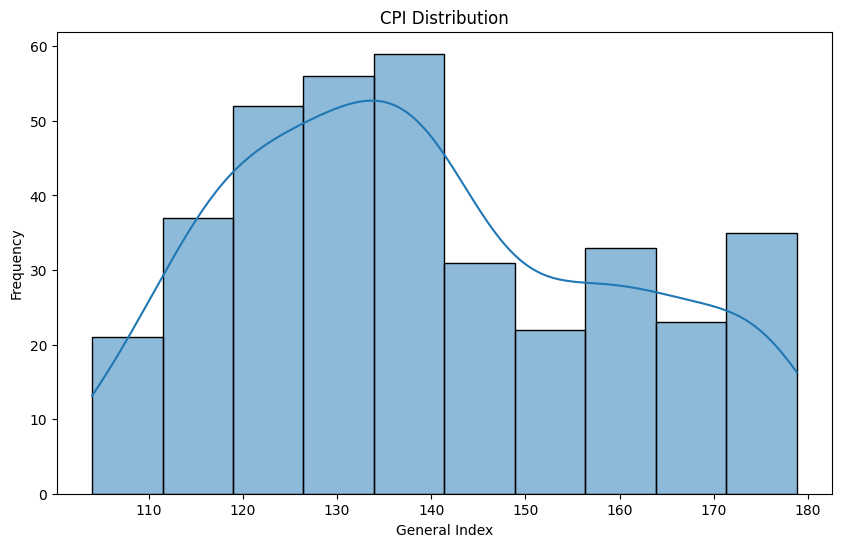

In [4]:
# Plot General index distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['General index'], kde=True)
plt.title('CPI Distribution')
plt.xlabel('General Index')
plt.ylabel('Frequency')
plt.show()

## 3. Model Training and Evaluation

In [5]:
# Prepare data for modeling
y = df['General index']
X = df.drop('General index', axis=1)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models to compare
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'AdaBoost': AdaBoostRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'KNN': KNeighborsRegressor(),
    'Lasso': Lasso()
}

# Evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    results[name] = {
        'R2': r2,
        'RMSE': rmse,
        'MAE': mae
    }

# Display results
results_df = pd.DataFrame(results).T
print("\nModel Performance:\n", results_df)


Model Performance:
                          R2      RMSE       MAE
Linear Regression  0.999309  0.529271  0.327083
Random Forest      0.999082  0.610410  0.486132
AdaBoost           0.997591  0.988519  0.814409
Gradient Boosting  0.998883  0.673119  0.543702
KNN                0.972632  3.332103  2.696113
Lasso              0.996876  1.125789  0.958815


## 4. Hyperparameter Tuning


Best Model: Linear Regression
R2 Score: 0.9993
RMSE: 0.5293
MAE: 0.3271


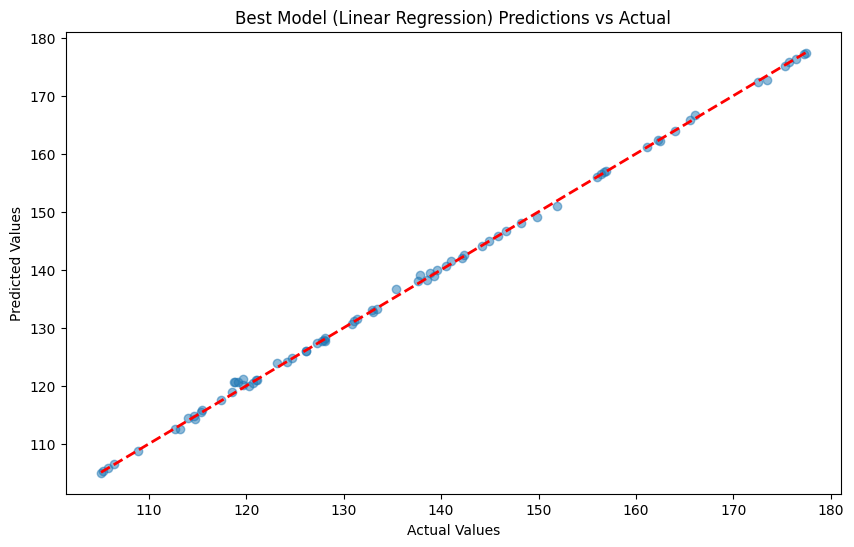

In [6]:
# Select top 2 models based on R2 score
top_models = results_df.sort_values('R2', ascending=False).head(2).index.tolist()

# Get the best model
best_model_name = top_models[0]
best_model = models[best_model_name]

# Train the best model on the full dataset
best_model.fit(X_train_scaled, y_train)
y_pred = best_model.predict(X_test_scaled)

# Calculate metrics for the best model
best_r2 = r2_score(y_test, y_pred)
best_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
best_mae = mean_absolute_error(y_test, y_pred)

# Print best model performance
print(f"\nBest Model: {best_model_name}")
print(f"R2 Score: {best_r2:.4f}")
print(f"RMSE: {best_rmse:.4f}")
print(f"MAE: {best_mae:.4f}")

# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Best Model ({best_model_name}) Predictions vs Actual')
plt.show()

## 5. Save Best Model

In [7]:
# Select the best performing model
best_model = None
best_r2 = -np.inf

for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    r2 = r2_score(y_test, y_pred)
    
    if r2 > best_r2:
        best_r2 = r2
        best_model = model

# Save the best model
import joblib
joblib.dump(best_model, 'cpi_model.pkl')

# Also save the scaler
joblib.dump(scaler, 'scaler.pkl')

# Print results
print(f'\nBest model saved: {best_model.__class__.__name__}')
print(f'Best R2 score: {best_r2:.4f}')



Best model saved: LinearRegression
Best R2 score: 0.9993
